# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusions](#conclusions)
* [Sources](#sources)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Italian restaurant** in **paris**, France.
Paris has in total 20 boroughs (called arrondissements in French) and 80 neighborhoods (4 neighborhoods for each borough).
Various factors need to be studied in order to decide on the location such as:

* Italian restaurants in vicinity
* Total restaurants in vicinity
* Paris Population
* Median household income for the neighborhoods
* Average rent in the area
* Area popularity
* Distance from Paris center

The analysis and recommendations for new Italian restaurant locations will focus on general neighborhoods with these establishments, not on specific addresses. Narrowing down the best district options derived from analysis allows for either further research to be conducted, advising agents of the chosen district, or on the ground searching for specific sites by the stakeholders.

## Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decission and
the sources from which the relevant data are as follows: 
* Number of existing restaurants in the neighborhood, type and location will be obtained using **Foursquare API**
* Distance of neighborhood from the city center (Paris center was obtained using geopy library)
* Data set of paris quartier obtained from [[1]](#1)
* Data set of paris arrondissements obtained from [[2]](#2)
* The relevant data of Paris Population and Median household income for each arrondissements obtained from [[3]](#3)
* Data set of Average rent in each arrondissements obtained from [[4]](#4)
* The rank that was given for each arrondissements based on the data from [[5]](#5)

Before we start with the main lab content, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Download and Explore city of Paris geographical coordinates dataset

Paris has a total of 20 boroughs (arrondissements in french) and 80 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 20 boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood.

#### Get the data set of paris quartier.

In [3]:
with open('quartier_paris.json') as json_data:
    newyork_data = json.load(json_data)

####  Transform the data into a *pandas* dataframe.

In [4]:
quartier_paris=pd.json_normalize(newyork_data)
quartier_paris.head()

,datasetid,recordid,record_timestamp,fields.n_sq_qu,fields.perimetre,fields.geom_x_y,fields.c_qu,fields.surface,fields.l_qu,fields.geom.type,fields.geom.coordinates,fields.n_sq_ar,fields.c_quinsee,fields.c_ar,geometry.type,geometry.coordinates
0,quartier_paris,a69f1a28df15be495f47c1d57ee2a47c232623ce,2020-04-01T12:00:57.071+02:00,750000027,3887.703157,"[48.8503592615, 2.31103093627]",27,8.078708e+05,Ecole-Militaire,Polygon,"[[[2.320083673707669, 48.84818013038714], [2.3...",750000007,7510703,7,Point,"[2.31103093627, 48.8503592615]"
1,quartier_paris,c81cbe6fafa11351647293ad0bb8c42366fe364a,2020-04-01T12:00:57.071+02:00,750000059,4932.937240,"[48.8501716555, 2.2918526427]",59,1.478299e+06,Grenelle,Polygon,"[[[2.300883876325741, 48.85117615604929], [2.3...",750000015,7511503,15,Point,"[2.2918526427, 48.8501716555]"
2,quartier_paris,a3513423d69a238ac6d5b30bf18339da3846b27f,2020-04-01T12:00:57.071+02:00,750000061,12452.253931,"[48.8506223427, 2.25227690754]",61,6.383888e+06,Auteuil,Polygon,"[[[2.249224929777843, 48.85782761493475], [2.2...",750000016,7511601,16,Point,"[2.25227690754, 48.8506223427]"
3,quartier_paris,30eac957573eeeec98ed8add4d8657517c0ea59f,2020-04-01T12:00:57.071+02:00,750000012,1861.804114,"[48.862557245, 2.35485151825]",12,2.133164e+05,Sainte-Avoie,Polygon,"[[[2.358217680434203, 48.86122492296987], [2.3...",750000003,7510304,3,Point,"[2.35485151825, 48.862557245]"
4,quartier_paris,57fbc66fe26432ee1854451c75aea0d4565a05d3,2020-04-01T12:00:57.071+02:00,750000040,4453.177991,"[48.87600829, 2.36812301789]",40,8.837260e+05,Hôpital-Saint-Louis,Polygon,"[[[2.372433913673534, 48.876106393176826], [2....",750000010,7511004,10,Point,"[2.36812301789, 48.87600829]"


In [5]:
# Extract the Latitude and Longitude for each quartier and set the values in new columns
for i in range(len(quartier_paris)):
    quartier_paris.loc[i,'Latitude']=quartier_paris.loc[i,'geometry.coordinates'][1]
    quartier_paris.loc[i,'Longitude']=quartier_paris.loc[i,'geometry.coordinates'][0]
quartier_paris.drop('geometry.coordinates',1,inplace=True)

# convert the features to float type
quartier_paris['Latitude']=quartier_paris['Latitude'].astype(float)
quartier_paris['Longitude']=quartier_paris['Longitude'].astype(float)

quartier_paris.head()

,datasetid,recordid,record_timestamp,fields.n_sq_qu,fields.perimetre,fields.geom_x_y,fields.c_qu,fields.surface,fields.l_qu,fields.geom.type,fields.geom.coordinates,fields.n_sq_ar,fields.c_quinsee,fields.c_ar,geometry.type,Latitude,Longitude
0,quartier_paris,a69f1a28df15be495f47c1d57ee2a47c232623ce,2020-04-01T12:00:57.071+02:00,750000027,3887.703157,"[48.8503592615, 2.31103093627]",27,8.078708e+05,Ecole-Militaire,Polygon,"[[[2.320083673707669, 48.84818013038714], [2.3...",750000007,7510703,7,Point,48.850359,2.311031
1,quartier_paris,c81cbe6fafa11351647293ad0bb8c42366fe364a,2020-04-01T12:00:57.071+02:00,750000059,4932.937240,"[48.8501716555, 2.2918526427]",59,1.478299e+06,Grenelle,Polygon,"[[[2.300883876325741, 48.85117615604929], [2.3...",750000015,7511503,15,Point,48.850172,2.291853
2,quartier_paris,a3513423d69a238ac6d5b30bf18339da3846b27f,2020-04-01T12:00:57.071+02:00,750000061,12452.253931,"[48.8506223427, 2.25227690754]",61,6.383888e+06,Auteuil,Polygon,"[[[2.249224929777843, 48.85782761493475], [2.2...",750000016,7511601,16,Point,48.850622,2.252277
3,quartier_paris,30eac957573eeeec98ed8add4d8657517c0ea59f,2020-04-01T12:00:57.071+02:00,750000012,1861.804114,"[48.862557245, 2.35485151825]",12,2.133164e+05,Sainte-Avoie,Polygon,"[[[2.358217680434203, 48.86122492296987], [2.3...",750000003,7510304,3,Point,48.862557,2.354852
4,quartier_paris,57fbc66fe26432ee1854451c75aea0d4565a05d3,2020-04-01T12:00:57.071+02:00,750000040,4453.177991,"[48.87600829, 2.36812301789]",40,8.837260e+05,Hôpital-Saint-Louis,Polygon,"[[[2.372433913673534, 48.876106393176826], [2....",750000010,7511004,10,Point,48.876008,2.368123


In [6]:
# filter columns
quartier_paris=quartier_paris[['fields.c_qu','fields.l_qu','fields.c_ar','Latitude','Longitude']]

# new column names
new_column=['quartier_number','quartier_name','arrondissement_number','Latitude','Longitude']
quartier_paris.columns=new_column

quartier_paris.head()

,quartier_number,quartier_name,arrondissement_number,Latitude,Longitude
0,27,Ecole-Militaire,7,48.850359,2.311031
1,59,Grenelle,15,48.850172,2.291853
2,61,Auteuil,16,48.850622,2.252277
3,12,Sainte-Avoie,3,48.862557,2.354852
4,40,Hôpital-Saint-Louis,10,48.876008,2.368123


#### Get the data set of paris arrondissement.

In [7]:
Borough_paris=pd.read_csv('arrondissements.csv',sep=';')
Borough_paris.head()

,N_SQ_AR,C_AR,C_ARINSEE,L_AR,L_AROFF,N_SQ_CO,SURFACE,PERIMETRE,Geometry X Y,Geometry,OBJECTID,LONGUEUR
0,750000002,2,75102,2ème Ardt,Bourse,750001537,9.911537e+05,4554.104360,"48.8682792225,2.34280254689","{""type"": ""Polygon"", ""coordinates"": [[[2.351518...",2,4553.938764
1,750000017,17,75117,17ème Ardt,Batignolles-Monceau,750001537,5.668835e+06,10775.579516,"48.887326522,2.30677699057","{""type"": ""Polygon"", ""coordinates"": [[[2.295166...",17,10775.348915
2,750000007,7,75107,7ème Ardt,Palais-Bourbon,750001537,4.090057e+06,8099.424883,"48.8561744288,2.31218769148","{""type"": ""Polygon"", ""coordinates"": [[[2.320902...",7,8099.033151
3,750000003,3,75103,3ème Ardt,Temple,750001537,1.170883e+06,4519.263648,"48.86287238,2.3600009859","{""type"": ""Polygon"", ""coordinates"": [[[2.363828...",3,4519.071982
4,750000001,1,75101,1er Ardt,Louvre,750001537,1.824613e+06,6054.936862,"48.8625627018,2.33644336205","{""type"": ""Polygon"", ""coordinates"": [[[2.328007...",1,6054.680862


In [8]:
# filter columns
Borough_paris=Borough_paris[['N_SQ_AR','C_AR','L_AROFF','Geometry X Y']]

# new column names 
new_column=['postal_codes','arrondissement_number','arrondissement_name','Geometry X Y']
Borough_paris.columns=new_column

# split the Geometry X Y feature
Borough_paris['Geometry X Y']=Borough_paris['Geometry X Y'].apply(lambda x: x.split(','))

Borough_paris.head()

,postal_codes,arrondissement_number,arrondissement_name,Geometry X Y
0,750000002,2,Bourse,"[48.8682792225, 2.34280254689]"
1,750000017,17,Batignolles-Monceau,"[48.887326522, 2.30677699057]"
2,750000007,7,Palais-Bourbon,"[48.8561744288, 2.31218769148]"
3,750000003,3,Temple,"[48.86287238, 2.3600009859]"
4,750000001,1,Louvre,"[48.8625627018, 2.33644336205]"


In [9]:
# Extract the Latitude and Longitude for each quartier and set the values in new columns
for i in range(len(Borough_paris)):
    Borough_paris.loc[i,'Latitude']=Borough_paris.loc[i,'Geometry X Y'][0]
    Borough_paris.loc[i,'Longitude']=Borough_paris.loc[i,'Geometry X Y'][1]
    
# drop 'Geometry X Y' column
Borough_paris.drop('Geometry X Y',1,inplace=True)

# convert the features to float type
Borough_paris['Latitude']=Borough_paris['Latitude'].astype(float)
Borough_paris['Longitude']=Borough_paris['Longitude'].astype(float)

Borough_paris.head()

,postal_codes,arrondissement_number,arrondissement_name,Latitude,Longitude
0,750000002,2,Bourse,48.868279,2.342803
1,750000017,17,Batignolles-Monceau,48.887327,2.306777
2,750000007,7,Palais-Bourbon,48.856174,2.312188
3,750000003,3,Temple,48.862872,2.360001
4,750000001,1,Louvre,48.862563,2.336443


#### Use geopy library to get the latitude and longitude values of Paris City.

In [10]:
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
paris_center=[latitude,longitude]
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris City are 48.8566969, 2.3514616.


#### Create a map of Paris with arrondissement superimposed on top and the borders of Paris arrondissement.

In [11]:
def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [12]:
map_paris_arr=folium.Map(location=paris_center,zoom_start=12)

for lat,lng, label in zip(Borough_paris.Latitude,Borough_paris.Longitude,Borough_paris.arrondissement_name):
    folium.features.CircleMarker([lat,lng],radius=5,color='blue',fill=True,fillcolor='#3186cc',fill_opacity=0.5,popup=folium.Popup(label, parse_html=True, max_width=100)).add_to(map_paris_arr)

paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(map_paris_arr)
map_paris_arr

#### Create a map of Paris with quartier superimposed on top.

In [133]:
map_paris_quartier=folium.Map(location=[latitude,longitude],zoom_start=12)
num_of_arr=20

rainbow=cm.rainbow(np.linspace(0,1,num_of_arr))
for index,row in quartier_paris.iterrows():
    col=colors.rgb2hex(rainbow[row.arrondissement_number-1])
    lat=row.Latitude
    lng=row.Longitude
    label='{}, arrondissement: {}.'.format(row.quartier_name,row.arrondissement_number)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker([lat,lng],radius=5,fill=True,color=col,fill_opacity=1,popup=label).add_to(map_paris_quartier)

paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(map_paris_quartier)
map_paris_quartier

## Use the Foursquare API to explore the Arrondissements of Paris (Neighborhoods)


#### Define Foursquare Credentials and Version.

In [14]:
CLIENT_ID = '5D2DYO3GXYYO0JJMCAV5OY1BE0F1PKJGCWPIPQWLSOYZ0UF1' # your Foursquare ID
CLIENT_SECRET = 'CLN5DS13BACANKFCSACOWTM4LK3HMA0YFURSH4FF35IDJDGR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5D2DYO3GXYYO0JJMCAV5OY1BE0F1PKJGCWPIPQWLSOYZ0UF1
CLIENT_SECRET:CLN5DS13BACANKFCSACOWTM4LK3HMA0YFURSH4FF35IDJDGR


## Explore Neighborhoods in paris

Create a nearby venues function for all the neighborhoods in Paris.

In [15]:
# Category IDs corresponding to Italian restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

italian_restaurant_categories = ['4bf58dd8d48988d110941735','55a5a1ebe4b013909087cbb6','55a5a1ebe4b013909087cb7c',
                                 '55a5a1ebe4b013909087cba7','55a5a1ebe4b013909087cba1','55a5a1ebe4b013909087cba4',
                                 '55a5a1ebe4b013909087cb95','55a5a1ebe4b013909087cb89','55a5a1ebe4b013909087cb9b',
                                 '55a5a1ebe4b013909087cb98','55a5a1ebe4b013909087cbbf','55a5a1ebe4b013909087cb79',
                                 '55a5a1ebe4b013909087cbb0','55a5a1ebe4b013909087cbb3','55a5a1ebe4b013909087cb74',
                                 '55a5a1ebe4b013909087cbaa','55a5a1ebe4b013909087cb83','55a5a1ebe4b013909087cb8c',
                                 '55a5a1ebe4b013909087cb92','55a5a1ebe4b013909087cb8f','55a5a1ebe4b013909087cb86',
                                 '55a5a1ebe4b013909087cbb9','55a5a1ebe4b013909087cb7f','55a5a1ebe4b013909087cbbc',
                                 '55a5a1ebe4b013909087cb9e','55a5a1ebe4b013909087cbc2','55a5a1ebe4b013909087cbad']


def get_categories(categories):
    return[(cat['name'],cat['id']) for cat in categories]

def is_restaurant(categories,specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    restaurant = False
    specific = False
    category_name=categories[0][0].lower()
    category_id=categories[0][1]
    for r in restaurant_words:
        if r in category_name:
            restaurant=True 
    if 'fast food' in category_name:
        restaurant = False
    if not(specific_filter==None) and (category_id in specific_filter):
        restaurant=True
        specific=True
    return restaurant, specific

In [16]:
def get_restaurants(names, arr_number, latitudes, longitudes,radius=500):
    LIMIT = 250
    
    # using dictionaries to remove any duplicates resulting from area overlaps
    restaurants = {}

    for name, arr_num, lat, lng in zip(names,arr_number, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            food_category,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list=[(name, arr_num, lat, lng, item['venue']['id'],
                item['venue']['name'],
                (item['venue']['location']['lat'],item['venue']['location']['lng']),
                 get_categories(item['venue']['categories'])) for item in results]
        #print(venues_list)
        for venues in venues_list:
            venue_id=venues[4]
            venue_name=venues[5]
            venue_latlon=venues[6]
            venue_categories=venues[7]
            is_res, is_italian=is_restaurant(venue_categories, specific_filter=italian_restaurant_categories)
            if is_res:
                restaurant=(name,arr_num,lat,lng,venue_id,venue_name,venue_latlon[0],venue_latlon[1],venue_categories,is_italian)
                restaurants[venue_id]=restaurant
    return restaurants

#### Now write the code to run the above function on each quartier and create the restaurants data.

In [17]:
restaurants=get_restaurants(quartier_paris.quartier_name, quartier_paris.arrondissement_number,
                            quartier_paris.Latitude, quartier_paris.Longitude, radius=750)

Convert the dictionary to data frame.

In [18]:
df_restaurants=pd.DataFrame(restaurants)
df_restaurants=df_restaurants.transpose()
columns=['quartier_name','arrondissement_number','quartier_lat','quartier_lng','venue_id','venue_name','venue_lat','venue_lng','venue_categories','is_italian']
df_restaurants.columns=columns
df_restaurants.reset_index(drop=True,inplace=True)
df_restaurants.head()

,quartier_name,arrondissement_number,quartier_lat,quartier_lng,venue_id,venue_name,venue_lat,venue_lng,venue_categories,is_italian
0,Necker,15,48.8427,2.31078,4bb62124f562ef3ba7a92f97,L’Antre Amis,48.8467,2.31022,"[(French Restaurant, 4bf58dd8d48988d10c941735)]",False
1,Ecole-Militaire,7,48.8504,2.31103,4d714543a8df6dcb224030c1,Lily Wang,48.85,2.31242,"[(Asian Restaurant, 4bf58dd8d48988d142941735)]",False
2,Ecole-Militaire,7,48.8504,2.31103,4b7261eaf964a5205a792de3,D'Chez Eux,48.8535,2.30951,"[(French Restaurant, 4bf58dd8d48988d10c941735)]",False
3,Ecole-Militaire,7,48.8504,2.31103,5612e7b7498e3e3b22d91e5e,Escudella,48.8507,2.30897,"[(French Restaurant, 4bf58dd8d48988d10c941735)]",False
4,Necker,15,48.8427,2.31078,55e09d6d498ebe455fee5d7d,Le Radis Beurre,48.8463,2.30771,"[(French Restaurant, 4bf58dd8d48988d10c941735)]",False


Create data frame for the italian restaurants only.

In [19]:
df_restaurants_italian=df_restaurants[df_restaurants.loc[:,'is_italian']==True].reset_index(drop=True)
df_restaurants_italian.head()

,quartier_name,arrondissement_number,quartier_lat,quartier_lng,venue_id,venue_name,venue_lat,venue_lng,venue_categories,is_italian
0,Notre-Dame-des-Champs,6,48.8464,2.32736,5085b3bce4b0a896863033d5,Gemini,48.8489,2.32042,"[(Italian Restaurant, 4bf58dd8d48988d110941735)]",True
1,Necker,15,48.8427,2.31078,4b824371f964a52080ce30e3,Fontanarosa,48.8469,2.30474,"[(Italian Restaurant, 4bf58dd8d48988d110941735)]",True
2,Ecole-Militaire,7,48.8504,2.31103,4bf813fb8d30d13abf0d0018,Le Sept Quinze,48.8491,2.30328,"[(Italian Restaurant, 4bf58dd8d48988d110941735)]",True
3,Invalides,7,48.8585,2.31644,4bbcebcb593fef3b23d10256,Les Parisiennes,48.8559,2.30814,"[(Italian Restaurant, 4bf58dd8d48988d110941735)]",True
4,Necker,15,48.8427,2.31078,4adcda12f964a5205d3621e3,Swann et Vincent,48.8469,2.30498,"[(Italian Restaurant, 4bf58dd8d48988d110941735)]",True


#### Let's create dictionaries with the population density per square kilometre, median household income, grading and average rent for each arrondissement.

#### Density of Population per square kilometre

In [20]:
density={1:17400,2:23000,3:36100,4:27900,5:60000,6:43900,7:57800,8:40600,9:59400,10:94000,11:154650,12:144720,13:183260,14:140300,15:237100,16:170000,17:170170,18:203100,19:160100,20:198000}
density

{1: 17400,
 2: 23000,
 3: 36100,
 4: 27900,
 5: 60000,
 6: 43900,
 7: 57800,
 8: 40600,
 9: 59400,
 10: 94000,
 11: 154650,
 12: 144720,
 13: 183260,
 14: 140300,
 15: 237100,
 16: 170000,
 17: 170170,
 18: 203100,
 19: 160100,
 20: 198000}

#### Median household income

In [21]:
income={1:38830,2:34130,3:36370,4:37560,5:38780,6:46770,7:50080,8:51970,9:38000,10:31810,11:31620,12:35120,13:31560,14:34550,15:37840,16:48750,17:37000,18:27600,19:28400,20:28970}
income

{1: 38830,
 2: 34130,
 3: 36370,
 4: 37560,
 5: 38780,
 6: 46770,
 7: 50080,
 8: 51970,
 9: 38000,
 10: 31810,
 11: 31620,
 12: 35120,
 13: 31560,
 14: 34550,
 15: 37840,
 16: 48750,
 17: 37000,
 18: 27600,
 19: 28400,
 20: 28970}

#### The top Paris arrondissements for tourists (ranked from worst to best)

In [22]:
top_paris={'rank 20':16,'rank 19':15,'rank 18':17,'rank 17':13,'rank 16':11,'rank 15':19,'rank 14':20,'rank 13':14,'rank 12':12,'rank 11':10,'rank 10':9,'rank 9':2,'rank 8':8,'rank 7':3,'rank 6':6,'rank 5':4,'rank 4':18,'rank 3':1,'rank 2':7,'rank 1':5}
top_paris

{'rank 20': 16,
 'rank 19': 15,
 'rank 18': 17,
 'rank 17': 13,
 'rank 16': 11,
 'rank 15': 19,
 'rank 14': 20,
 'rank 13': 14,
 'rank 12': 12,
 'rank 11': 10,
 'rank 10': 9,
 'rank 9': 2,
 'rank 8': 8,
 'rank 7': 3,
 'rank 6': 6,
 'rank 5': 4,
 'rank 4': 18,
 'rank 3': 1,
 'rank 2': 7,
 'rank 1': 5}

#### Average rent per square meter (in euros).

In [23]:
rent={1:30.8,2:30,3:30,4:30.4,5:29.3,6:30.4,7:30.5,8:28.3,9:26.7,10:26.1,11:26.4,12:24.9,13:24.7,14:25.6,15:25.9,16:26.9,17:26.7,18:24.9,19:22.7,20:23.5}
rent

{1: 30.8,
 2: 30,
 3: 30,
 4: 30.4,
 5: 29.3,
 6: 30.4,
 7: 30.5,
 8: 28.3,
 9: 26.7,
 10: 26.1,
 11: 26.4,
 12: 24.9,
 13: 24.7,
 14: 25.6,
 15: 25.9,
 16: 26.9,
 17: 26.7,
 18: 24.9,
 19: 22.7,
 20: 23.5}

## Methodology<a name="methodology"></a>

In the project presented here we try to determine the suitable areas in which to open an Italian restaurant in Paris, France. Paris is divided to 20 administrative districts, more simply referred to as arrondissements. Every arrondissement is divided to 4 quarters. Each arrondissement has some distinctive and unique features. Therefore, in order to decide upon the best area in which to open an Italian restaurant, we will need to perform a segmentation of the data available on each arrondissement, while taking into account all the specific criteria that are of interest to the stakeholders.

In order to achieve this goal, we first collected the data of Paris neighborhoods locations, and performed data wrangling for further analysis. Then we used the Foursquare server in order to find all the restaurants and their type within a 750 meters radius in each neighborhood. After we identified all the Italian restaurants, we explored the density of the restaurants in general and of the Italian restaurants in particular in the different arrondissements, by creating Heatmaps.

The second step in our analysis will be to gather more information regarding the different arrondissements in Paris, in order to choose the most promising location. We will collect data about population density, average annual household income, average rent prices, and general score of the various arrondissements. The data was used at a later stage in the segmentation process.
 

The third and final step will focus on segmentation of the quarters in Paris. This will be achieved by clustering all the data we obtained, using the K-means algorithm, and creating clusters that are comprised of the quarters. K-Means algorithm is one of the most common clustering method of unsupervised machine learning algorithms. We will also present the map of the clustered neighborhoods, using Geopy and Folium libraries.

# Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's see the ratio between the number of italian restaurants and the total number of restaurants in each arrondissement. We can visualize the percentage (%) of italian restaurants in each arrondissement using a bar plot graph. 

In [24]:
restaurant_count=df_restaurants.groupby(['arrondissement_number']).agg({'is_italian': [lambda x :(x==True).sum(),'count']})
restaurant_count.columns=['Italian resterunts','Total resterunts']
restaurant_count['italian_ratio']=round(100*restaurant_count['Italian resterunts']/restaurant_count['Total resterunts'],2)
restaurant_count.head()

,Italian resterunts,Total resterunts,italian_ratio
arrondissement_number,,,
1,14,118,11.86
2,8,70,11.43
3,10,113,8.85
4,7,50,14.00
5,15,131,11.45


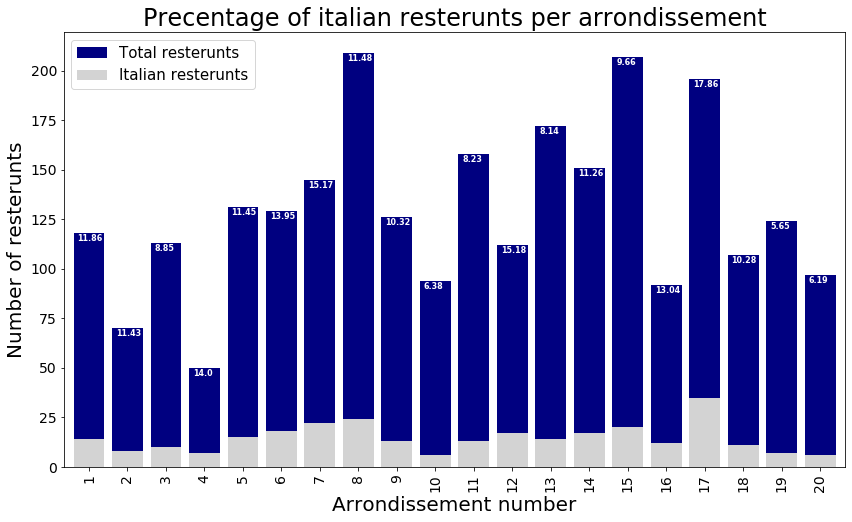

In [126]:
restaurant_count=df_restaurants.groupby(['arrondissement_number']).agg({'is_italian': [lambda x :(x==True).sum(),'count']})
restaurant_count.columns=['Italian resterunts','Total resterunts']
restaurant_count['italian_ratio']=round(100*restaurant_count['Italian resterunts']/restaurant_count['Total resterunts'],2)

restaurant_count['Total resterunts'].plot(kind='bar',figsize=(14,8),fontsize=14,color=['navy'], width=0.8)
restaurant_count['Italian resterunts'].plot(kind='bar',fontsize=14,color=['lightgrey'], width=0.8)

plt.xlabel('Arrondissement number',fontsize=20)
plt.ylabel('Number of resterunts',fontsize=20)
plt.title('Precentage of italian resterunts per arrondissement',fontsize=24)
plt.legend(fontsize=15)
for i in range(len(restaurant_count)): 
    plt.annotate(restaurant_count.iloc[i,2], xy=(i-0.3,restaurant_count.iloc[i,1]-4), color='white',fontsize=8,fontweight="bold")

Let's create a map **showing heatmap / density** of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Paris arrondissement on our map.

In [26]:
# get latitude and longitude of resterunts
resterunt_latlons=df_restaurants[['venue_lat','venue_lng']]
resterunt_latlons=[[resterunt_latlons.iloc[i,0],resterunt_latlons.iloc[i,1]] for i in range(len(resterunt_latlons))]

# Get the latitude and longitude for italian resterunts only
italian_latlons=df_restaurants_italian[['venue_lat','venue_lng']]
italian_latlons=[[italian_latlons.iloc[i,0],italian_latlons.iloc[i,1]] for i in range(len(italian_latlons))]

In [127]:
from folium import plugins
from folium.plugins import HeatMap

paris_map = folium.Map(location=paris_center, zoom_start=13)

paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(paris_map)
HeatMap(resterunt_latlons).add_to(paris_map)
folium.Marker(paris_center,popup='Paris center').add_to(paris_map)
paris_map

Restaurant density can be seen to be high in all arrondissements, but a few low density pockets can be found throughout the city.

Let's create another **heatmap map showing heatmap/density of Italian restaurants** only.

In [128]:
from folium import plugins
from folium.plugins import HeatMap

paris_map = folium.Map(location=paris_center, zoom_start=12)
paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(paris_map)
HeatMap(italian_latlons).add_to(paris_map)
folium.Marker(paris_center).add_to(paris_map)
paris_map

This map is not so 'hot' (Italian restaurants represent a subset of ~11% of all restaurants in Paris) but it also indicates higher density of existing Italian restaurants directly **north and west** from Paris center,**east-west** and **west-south**.
These heat maps can help us choose the best quarters for opening the restaurant after we apply the segmentation of all the quarters.

#### Density of Population per km^2

Tranform the density data into a *pandas* dataframe.

In [29]:
df_density=pd.DataFrame([density]).transpose()
df_density.columns=['Population density']
df_density.index=np.arange(1,21)
df_density.index.name = 'arrondissement_number'
df_density.head()

,Population density
arrondissement_number,
1,17400
2,23000
3,36100
4,27900
5,60000


#### Median household income

Tranform the Median household income data into a *pandas* dataframe.

In [30]:
df_income=pd.DataFrame([income]).transpose()
df_income.columns=['Income']
df_income.index=np.arange(1,21)
df_income.index.name='arrondissement_number'
df_income.head()

,Income
arrondissement_number,
1,38830
2,34130
3,36370
4,37560
5,38780


#### The top Paris arrondissements for tourists (ranked from worst to best)

Tranform the top Paris arrondissements data into a *pandas* dataframe.

In [31]:
df_top_paris=pd.DataFrame([top_paris]).transpose()
df_top_paris.columns=['arrondissement_number']
df_top_paris['Grade']=np.linspace(0,100,20)
df_top_paris['Grade']=round(df_top_paris['Grade'],2)
df_top_paris.head()

,arrondissement_number,Grade
rank 20,16,0.00
rank 19,15,5.26
rank 18,17,10.53
rank 17,13,15.79
rank 16,11,21.05


#### Average rent per square meter (in euros)

Tranform the Average rent per square meter data into a *pandas* dataframe.

In [32]:
df_rent=pd.DataFrame([rent]).transpose()
df_rent.columns=['Rent']
df_rent.index=np.arange(1,21)
df_rent.index.name = 'arrondissement_number'
df_rent.head()

,Rent
arrondissement_number,
1,30.8
2,30.0
3,30.0
4,30.4
5,29.3


#### Let's summarize the data shown above in bar plot

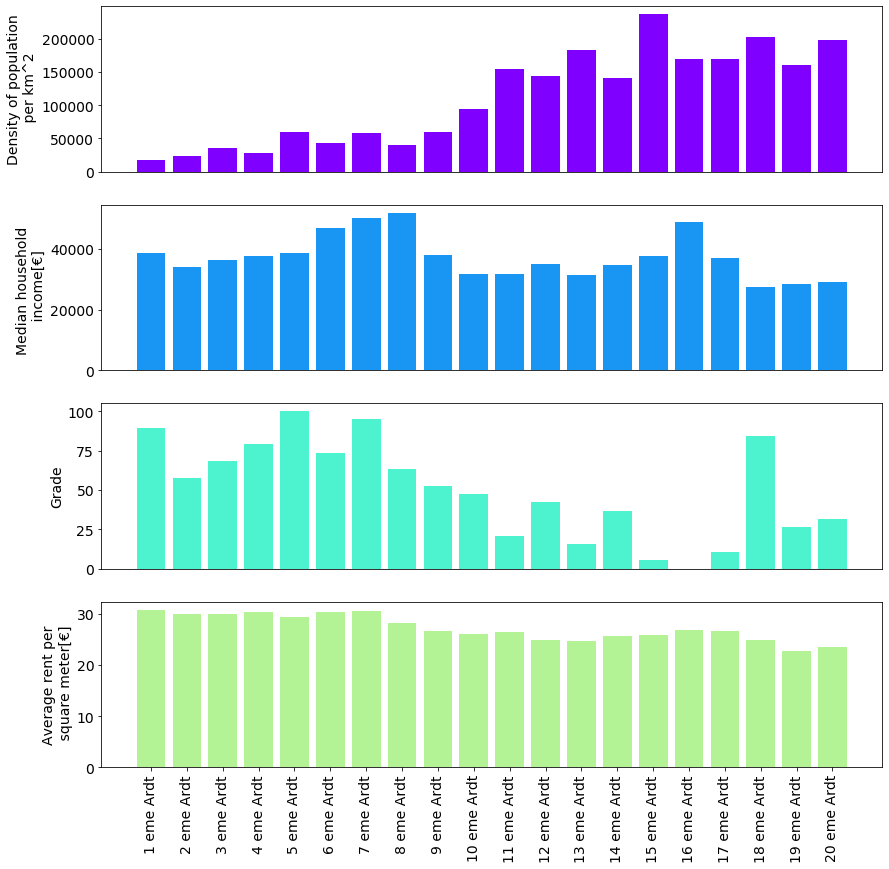

In [123]:
color=cm.rainbow(np.linspace(0,1,6))

fig=plt.figure(figsize=(14,14))
ax1=fig.add_subplot(4,1,1)
ax1.bar(list(density.keys()),density.values(),color=color[0])
ax1.set_ylabel('Density of population\n per km^2',fontsize=14)
ax1.set_xticks([])
ax1.tick_params(labelsize=14)


ax2=fig.add_subplot(4,1,2)
ax2.bar(list(income.keys()),income.values(),color=color[1])
ax2.set_ylabel('Median household \n income[€]',fontsize=14)
ax2.set_xticks([])
ax2.tick_params(labelsize=14)


ax3=fig.add_subplot(4,1,3)
ax3.bar(df_top_paris.arrondissement_number,df_top_paris.Grade,color=color[2])
ax3.set_ylabel('Grade',fontsize=14)
ax3.set_xticks([])
ax3.tick_params(labelsize=14)


ax4=fig.add_subplot(4,1,4)
ax4.bar(list(rent.keys()),rent.values(),color=color[3])
ax4.set_ylabel('Average rent per\n square meter[€]',fontsize=14)

xticks=np.arange(1, 21, step=1)
label=[(str(i)+' eme Ardt') for i in range(1,len(rent)+1)]
ax4.set_xticks(xticks)
ax4.set_xticklabels(label,rotation=90,fontsize=14)
ax4.tick_params(labelsize=14)
plt.show()
fig.savefig("foo.png", bbox_inches='tight', dpi=600)

We can observe from these graphs a big variance in the first three parameters namely, **Density of population, Median household income and Grade,** between the different arrandosments.
In contrast, the **Average rent per square meter** does not vary significantly between the different arrondissement.

We can support this claim by calculating the standard deviation (std) for each parameter.

In [34]:
print('Density of population (mean,std): ({:.2f},{:.2f})'.format(df_density['Population density'].mean(),df_density['Population density'].std()))
print('Median household income (mean,std): ({:.2f},{:.2f})'.format(df_income['Income'].mean(),df_income['Income'].std()))
print('Grade (mean,std): ({:.2f},{:.2f})'.format(df_top_paris['Grade'].mean(),df_top_paris['Grade'].std()))
print('\033[0;37;40m Average rent per square meter (mean,std): ({:.2f},{:.2f})'.format(df_rent['Rent'].mean(),df_rent['Rent'].std()))

Density of population (mean,std): (111075.00,71572.46)
Median household income (mean,std): (37285.50,7130.57)
Grade (mean,std): (50.00,31.14)
 Average rent per square meter (mean,std): (27.23,2.55)


Let's see the ratio between the number of italian restaurants and the total number of restaurants in each quartier.

In [35]:
restaurant_count_quartier=df_restaurants.groupby(['quartier_name']).agg({'is_italian': [lambda x :(x==True).sum(),'count']})
restaurant_count_quartier.columns=['Italian resterunts','Total resterunts']
restaurant_count_quartier['italian_ratio']=round(100*restaurant_count_quartier['Italian resterunts']/restaurant_count_quartier['Total resterunts'],2)
restaurant_count_quartier.head()

,Italian resterunts,Total resterunts,italian_ratio
quartier_name,,,
Amérique,0,8,0.00
Archives,6,62,9.68
Arsenal,6,22,27.27
Arts-et-Métiers,3,38,7.89
Auteuil,0,16,0.00


#### Let's join the data shown above to one dataframe

In [36]:
quartier_paris=quartier_paris.join(df_density,on='arrondissement_number')
quartier_paris=quartier_paris.join(df_income,on='arrondissement_number')
quartier_paris=quartier_paris.join(df_rent,on='arrondissement_number')
quartier_paris=quartier_paris.join(df_top_paris.set_index('arrondissement_number'),on='arrondissement_number')
quartier_paris=quartier_paris.join(restaurant_count_quartier[['Italian resterunts','Total resterunts']],on='quartier_name')
quartier_paris.head()

,quartier_number,quartier_name,arrondissement_number,Latitude,Longitude,Population density,Income,Rent,Grade,Italian resterunts,Total resterunts
0,27,Ecole-Militaire,7,48.850359,2.311031,57800,50080,30.5,94.74,2.0,11.0
1,59,Grenelle,15,48.850172,2.291853,237100,37840,25.9,5.26,4.0,61.0
2,61,Auteuil,16,48.850622,2.252277,170000,48750,26.9,0.00,0.0,16.0
3,12,Sainte-Avoie,3,48.862557,2.354852,36100,36370,30.0,68.42,NaN,NaN
4,40,Hôpital-Saint-Louis,10,48.876008,2.368123,94000,31810,26.1,47.37,0.0,3.0


We want to find the distance between each quarter to center of Paris.
Let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters). This allows us to calculate distances in meters (not in latitude/longitude degrees).

In [37]:
#!pip install shapely
#!pip install pyproj

In [38]:
import pyproj
import math

In [39]:

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=31, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=31, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

In [40]:
paris_center_xy=lonlat_to_xy(paris_center[1],paris_center[0])
for index, row in quartier_paris.iterrows():
    quartier_xy=lonlat_to_xy(row.Longitude,row.Latitude)
    dis=calc_xy_distance(paris_center_xy[0],paris_center_xy[1],quartier_xy[0],quartier_xy[1])
    quartier_paris.loc[index,'dis']=round(dis,2)
quartier_paris.head()

,quartier_number,quartier_name,arrondissement_number,Latitude,Longitude,Population density,Income,Rent,Grade,Italian resterunts,Total resterunts,dis
0,27,Ecole-Militaire,7,48.850359,2.311031,57800,50080,30.5,94.74,2.0,11.0,3048.48
1,59,Grenelle,15,48.850172,2.291853,237100,37840,25.9,5.26,4.0,61.0,4432.62
2,61,Auteuil,16,48.850622,2.252277,170000,48750,26.9,0.00,0.0,16.0,7307.35
3,12,Sainte-Avoie,3,48.862557,2.354852,36100,36370,30.0,68.42,NaN,NaN,697.31
4,40,Hôpital-Saint-Louis,10,48.876008,2.368123,94000,31810,26.1,47.37,0.0,3.0,2470.17


### Cluster Neighborhoods and Exmine clusters 

Let us now cluster the quarters of paris to identifying similar arrondissement and their properties based on the dataset.

#### Normalizing over the standard deviation
Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally.

In [82]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# extract the necessary data for clustering
X=quartier_paris.loc[:,'Population density':'dis'].values
X = np.nan_to_num(X)

# normalize the data
#X = MinMaxScaler().fit(X).transform(X)
X = StandardScaler().fit_transform(X)

Let's determine the optimal value of K for our dataset using the Elbow and average silhouette methods.

**Average silhouette method:**

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.
For each observation i, the silhouette width si is calculated as follows:
Si=(bi−ai)/max(ai,bi), where:
ai = The mean distance between a sample and all other points in the same class.
bi = The mean distance between a sample and all other points in the next nearest cluster.
Finally the we calculate the mean Silhouette Coefficient over all samples.

**Elbow method:**

The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k and for each value of k calculate the sum of squared errors (SSE). SSE is defined as the sum of the squared distance between centroid and each member of the cluster.

In [90]:
from sklearn.metrics import silhouette_score
sil_coeff_arr=[]
distortions_arr=[]
k=range(2, 15)
for n in k:
    k_means = KMeans(init="k-means++", n_clusters=n, n_init=12)
    k_means.fit(X)
    label = k_means.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    sil_coeff_arr.append(sil_coeff)
    distortions=k_means.inertia_
    distortions_arr.append(distortions)
    print("For n_clusters={}, The Silhouette Coefficient is {}, distortions is {} ".format(n, sil_coeff,distortions))

For n_clusters=2, The Silhouette Coefficient is 0.3701018630230887, distortions is 329.3557324060857 
For n_clusters=3, The Silhouette Coefficient is 0.3343156896774701, distortions is 267.38520626510433 
For n_clusters=4, The Silhouette Coefficient is 0.29336707558187775, distortions is 211.93174185391337 
For n_clusters=5, The Silhouette Coefficient is 0.3080398750643186, distortions is 176.74885908947334 
For n_clusters=6, The Silhouette Coefficient is 0.3020491724697112, distortions is 156.68596140237798 
For n_clusters=7, The Silhouette Coefficient is 0.27512439862475213, distortions is 141.91218541852453 
For n_clusters=8, The Silhouette Coefficient is 0.2958604035704925, distortions is 126.58917607155524 
For n_clusters=9, The Silhouette Coefficient is 0.28877007169780156, distortions is 115.20885050714303 
For n_clusters=10, The Silhouette Coefficient is 0.29809542756935, distortions is 107.22922278252096 
For n_clusters=11, The Silhouette Coefficient is 0.31308788954281364, di

The following graph represents the average Silhouette Coefficient and sum of squared distance as a function of the number of clusters.

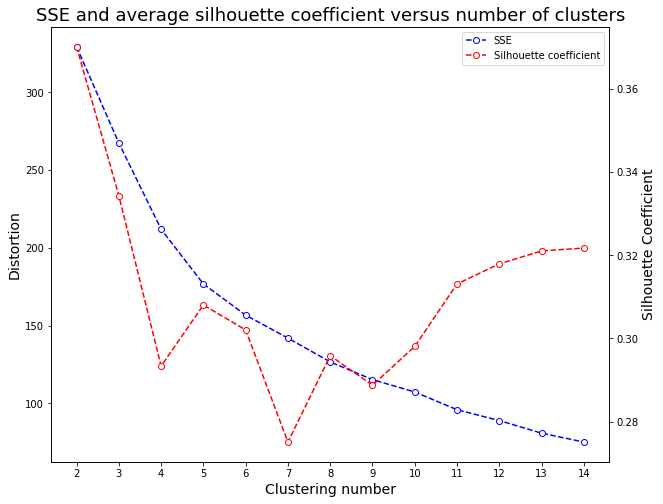

In [91]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1)
ax0.plot(k, distortions_arr, linestyle='--', color='b',marker='o',markerfacecolor='w',label='SSE')
ax0.set_xlabel('Clustering number',fontsize=14)
ax0.set_ylabel('Distortion',fontsize=14)

ax1 = ax0.twinx() 
ax1.plot(k, sil_coeff_arr,linestyle='--',color='r',marker='o',markerfacecolor='w',label='Silhouette coefficient')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Coefficient',fontsize=14)
ax1.set_title('SSE and average silhouette coefficient versus number of clusters',fontsize=18)
ax1.set_xticks(k)

ax0.plot(np.nan, linestyle='--',color='r',marker='o',markerfacecolor='w',label='Silhouette coefficient')  # Make an agent in ax
ax0.legend(loc=0)
plt.show()

Generally, a higher average silhouette coefficient indicates better clustering quality. In this view,
the optimal clustering number of arrondissement in the study area should be 2, at which the value of the
average silhouette coefficient is highest. However, the SSE of this clustering solution (k = 2) is too
large. At k = 5, the SSE is much lower. In addition, the value of the average silhouette coefficient at
k = 5 is also very high, which is just lower than k = 2. Thus, we use the clustering result at k = 5.

Run k-means to cluster the neighborhood into 5 clusters and assign the labels to each row in dataframe.

In [92]:
# set number of clusters
kclusters = 5

# run k-means clustering
k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(X)

# assign the labels
label = k_means.labels_
quartier_paris['Label']=label

We can easily check the centroid values by averaging the features in each cluster.

In [93]:
quartier_paris.groupby('Label').mean().loc[:,'Population density':'dis']

,Population density,Income,Rent,Grade,Italian resterunts,Total resterunts,dis
Label,,,,,,,
0,161820.000000,30552.400000,24.696000,40.000800,2.320000,28.040000,3403.638000
1,44891.666667,46130.000000,29.316667,75.000000,7.166667,60.000000,2382.900000
2,185114.615385,36583.076923,26.046154,14.574615,7.538462,59.076923,3781.183846
3,38570.833333,39016.666667,29.741667,75.656667,2.045455,16.863636,1462.975833
4,161601.666667,42248.333333,26.200000,15.791667,0.400000,8.200000,6276.915000


Now we can create a profile for each group, considering the common characteristics of each cluster.
It can be observed from the data that clusters 1 and 3 meets most of the criteria. We can label these clusters as follows:
* Cluster 1: The neighborhoods in this cluster are characterized by **close proximity to the city center**, high **grade**, and high **average household income**. However, these neighborhoods also have a low **population density** and relatively high **number of Italian restaurants**. 


* Cluster 3: The neighborhoods in this cluster are characterized by a very **close proximity to the city center**, high **grade**, a relatively low **number of Italian restaurants**, and high **average household income**. However, these neighborhoods also have a very low **population density**. 

Let us now join the labels to quartier_paris data frame

In [94]:
quartier_paris.head()

,quartier_number,quartier_name,arrondissement_number,Latitude,Longitude,Population density,Income,Rent,Grade,Italian resterunts,Total resterunts,dis,Label
0,27,Ecole-Militaire,7,48.850359,2.311031,57800,50080,30.5,94.74,2.0,11.0,3048.48,3
1,59,Grenelle,15,48.850172,2.291853,237100,37840,25.9,5.26,4.0,61.0,4432.62,2
2,61,Auteuil,16,48.850622,2.252277,170000,48750,26.9,0.00,0.0,16.0,7307.35,4
3,12,Sainte-Avoie,3,48.862557,2.354852,36100,36370,30.0,68.42,NaN,NaN,697.31,3
4,40,Hôpital-Saint-Louis,10,48.876008,2.368123,94000,31810,26.1,47.37,0.0,3.0,2470.17,0


Finally, let's visualize the resulting clusters on the heatmap/density of Italian restaurants.

In [129]:
map_cluster=folium.Map(location=paris_center,zoom_start=12)
num_of_cluster=len(quartier_paris.loc[:,'Label'].unique())

rainbow=cm.rainbow(np.linspace(0,1,num_of_cluster))
for index,row in quartier_paris.iterrows():
    col=colors.rgb2hex(rainbow[row.Label])
    lat=row.Latitude
    lng=row.Longitude
    label='{}, arrondissement: {}, Cluster {}.'.format(row.quartier_name,row.arrondissement_number,row.Label)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker([lat,lng],radius=5,fill=True,color=col,fill_opacity=1, popup=label).add_to(map_cluster)
    #folium.Circle([lat,lng],radius=350,fill=False,color='white').add_to(map_cluster)

paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(map_cluster)
HeatMap(italian_latlons).add_to(map_cluster)
map_cluster

Let's see some candidate neighborhoods which can be presented to the stakeholders. These neighborhoods belongs to Cluster 1 and Cluster 3. They are located in areas with low density of Italian restaurants are also located near to the city center.

In [96]:
# Create the candidate neighborhoods list
candidate=['Ecole-Militaire','Notre-Dame-des-Champs','Odéon','Monnaie','Notre-Dame','Saint-Merri','Halles']

# Extract the candidate from quartier_paris dataframe
df_candidate=quartier_paris.loc[quartier_paris.loc[:,'quartier_name'].isin (candidate)]
df_candidate=df_candidate.loc[:,'quartier_number':'Longitude'].reset_index(drop=True)

# Calculate UTM Cartesian coordinate for candidate
candidate_xy=lonlat_to_xy(df_candidate.loc[:,'Longitude'].to_list(),df_candidate.loc[:,'Latitude'].to_list())
df_candidate['X']=candidate_xy[0]
df_candidate['Y']=candidate_xy[1]
df_candidate['Label']=quartier_paris.loc[quartier_paris.loc[:,'quartier_name'].isin (candidate),'Label'].to_list()
df_candidate

,quartier_number,quartier_name,arrondissement_number,Latitude,Longitude,X,Y,Label
0,27,Ecole-Militaire,7,48.850359,2.311031,449456.433642,5.411050e+06,3
1,21,Monnaie,6,48.854384,2.340035,451588.100838,5.411479e+06,3
2,22,Odéon,6,48.847801,2.336339,451310.557771,5.410749e+06,3
3,13,Saint-Merri,4,48.858521,2.351667,452445.253980,5.411931e+06,3
4,16,Notre-Dame,4,48.852896,2.352775,452521.207748,5.411305e+06,3
5,23,Notre-Dame-des-Champs,6,48.846428,2.327357,450650.252620,5.410602e+06,1
6,2,Halles,1,48.862289,2.344899,451952.427690,5.412354e+06,1


In [98]:
# Extract UTM Cartesian coordinate
Coord=df_candidate.loc[:,'X':'Y'].values

# Create clusters for candidate neighborhoods
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
k_means.fit(Coord)
cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in k_means.cluster_centers_]


map_cluster=folium.Map(location=paris_center,zoom_start=12)
num_of_cluster=len(quartier_paris.loc[:,'Label'].unique())
rainbow=cm.rainbow(np.linspace(0,1,num_of_cluster))
for index,row in quartier_paris.iterrows():
    col=colors.rgb2hex(rainbow[row.Label])
    lat=row.Latitude
    lng=row.Longitude
    label='{}, arrondissement: {}, Cluster {}.'.format(row.quartier_name,row.arrondissement_number,row.Label)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker([lat,lng],radius=5,fill=True,color=col,fill_opacity=1, popup=label).add_to(map_cluster)
    #folium.Circle([lat,lng],radius=350,fill=False,color='white').add_to(map_cluster)
for lng, lat in cluster_centers:
    folium.features.Circle([lat,lng], radius=650, color='green', fill=True, fill_opacity=0.25).add_to(map_cluster)

paris_arrondissement_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/75-paris/communes-75-paris.geojson'
paris_arrondissement = requests.get(paris_arrondissement_url).json()
folium.GeoJson(paris_arrondissement, style_function=boroughs_style, name='geojson').add_to(map_cluster)
HeatMap(italian_latlons).add_to(map_cluster)
map_cluster

This concludes our analysis. We have created 3 representative zones containing neighborhoods with low number of Italian restaurants, which are fairly close to the city center and belong to clusters 1 and 3. These zones encompass an area included by a radius of ~650 meters (green circles) and their centers should be considered only as a starting point for exploring potential neighborhoods.

## Results and Discussion <a name="results"> </a>

Our analysis was comprised of a segmentation of the 80 neighborhoods in Paris. The segmentation was performed based on different parameters which are of importance when deciding upon the best location to open an Italian restaurant. The criteria that are of interest to the stakeholders, and thus are important when perfuming the segmentation, are as follows:

* An area with low density of restaurants in general, and of Italian restaurants in particular, in order to reduce the competition with active restaurants.

* An area with high population density, so the restaurant will be widely accessible.

* An area with higher-income neighborhoods, where income level might allow for a greater amount of spending than in lower-income neighborhoods.

* An area with Low rental prices on average, in order to reduce the routine monthly expanses.

* A popular tourist area, in order to increase sales.

 

All the data was collected and then analyzed in order to perform a segmentation of all the 80 neighborhoods of Paris, using the K-means clustering algorithm. By using the elbow and average silhouette methods we have found that the optimal value of K (number of clusters) is 5. Following the distribution of the neighborhoods to the different clusters, we created a profile for each cluster and chose the most suitable one.

 

The promising clusters, which met most of the criteria, were clusters 1 and 3. These clusters were labeled as follows:

* Cluster 1: The neighborhoods in this cluster are characterized by close proximity to the city center, high grade, and high average household income. However, these neighborhoods also have a low population density and relatively high number of Italian restaurants.

 

* Cluster 3: The neighborhoods in this cluster are characterized by a very close proximity to the city center, high grade, a relatively low number of Italian restaurants, and high average household income. However, these neighborhoods also have a very low population density.

In both clusters the average rent is similar, and thus it had no effect the on the decision about the best cluster.


Using the Clustered and Heat maps, we concluded that the following neighborhoods in the city of Paris represents a good starting point for opening an Italian resturant, and can be of interest to the stakeholders: **Notre-Dame-des-Champs, Halles** (part of cluster 1) and **Ecole-Militaire, Monnaie, Odéon, Saint-Merri, Notre-Dame** (part of cluster 3). These neighborhoods are located in areas with the lowest density of Italian restaurants and are fairly close to the city center. This of course does not imply that these neighborhoods are actually the optimal locations to open a new restaurant. The purpose of the analysis performed here was to narrow the search down to just a few possible locations that are best suit to match the criteria that was decided upon by the stakeholders. Recommended zones should therefore be considered only as a starting point for more detailed analysis, which should take into consideration more relevant factors. 

## Conclusions <a name="conclusions"> </a>

The purpose of this project was to identify the most suitable areas in Paris to open an Italian restaurant, based on pre-selected criteria, in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. Clustering of the different neighborhoods was performed by calculating the Italian restaurant density, and by collecting relevant data such as the average income, population density and average rent rates. Analysis of the results showed two promising clusterswhich met most of the criteria.  


Final decision on an optimal restaurant location will be made by stakeholders based on the weight they chose to give to each specific criterion  of the neighborhoods, while taking into consideration additional factors like attractiveness of each location (proximity to popular landmarks), levels of noise / proximity to major roads, public transportation availability etc.

## Sources <a name="sources"> </a>

[1] <a name="1"> </a> https://opendata.paris.fr/explore/dataset/quartier_paris/information/

[2] <a name="2"> </a>  https://www.data.gouv.fr/en/datasets/arrondissements-1/

[3] <a name="3"> </a>https://frenchmoments.eu/arrondissements-of-paris/

[4] <a name="4"> </a> https://www.statista.com/statistics/769062/rent-the-metre-square-apartments-by-districts-paris-la-france/

[5] <a name="5"> </a> https://theearfultower.com/2018/06/06/the-top-paris-arrondissements-for-tourists-ranked-from-worst-to-best/
